In [5]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import torch.nn.init as init
from torch.autograd import Variable
from dataLoader import loadData
from tensorflow import keras

In [6]:
!curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  3 5778k    3  220k    0     0   115k      0  0:00:50  0:00:01  0:00:49  115k
 33 5778k   33 1940k    0     0   693k      0  0:00:08  0:00:02  0:00:06  693k
100 5778k  100 5778k    0     0  1652k      0  0:00:03  0:00:03 --:--:-- 1652k
"unzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
‘ЁбвҐ¬Ґ ­Ґ г¤ Ґвбп ­ ©вЁ гЄ § ­­л© Їгвм.


In [77]:
!curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 4808k    0 11401    0     0  32855      0  0:02:29 --:--:--  0:02:29 32761
 14 4808k   14  699k    0     0   512k      0  0:00:09  0:00:01  0:00:08  511k
 22 4808k   22 1104k    0     0   451k      0  0:00:10  0:00:02  0:00:08  451k
 59 4808k   59 2864k    0     0   867k      0  0:00:05  0:00:03  0:00:02  867k
100 4808k  100 4808k    0     0  1157k      0  0:00:04  0:00:04 --:--:-- 1157k


In [10]:
import zipfile
with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
    
# !cd ml-1m/

In [78]:
import zipfile
with zipfile.ZipFile('ml-100k.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
    
# !cd ml-1m/

In [4]:
seed = 47
np.random.seed(seed)

We will use the following blogpost's independent code to benchmark our experiments https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea

# Independent MF code

In [23]:
names = ['user_id', 'item_id', 'rating']
df = pd.read_csv('./ml-1m/ratings.dat', sep='::', usecols = [0, 1, 2], names=names)
df.head()

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,user_id,item_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [25]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
n_users, n_items

(6040, 3706)

In [32]:
df.item_id.unique().max(), df.item_id.unique().shape, df.item_id.unique().max()

(3952, (3706,), 3952)

In [34]:
n_users = df.user_id.unique().max()
n_items = df.item_id.unique().max()
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
#     print(row)
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [36]:
def get_sparsity(mat):
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [37]:
get_sparsity(ratings)

4.190220560634904

In [64]:
def train_test_split(ratings):
    np.random.seed(seed)
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [73]:
train_1m, test_1m = train_test_split(ratings)

In [74]:
train_1m

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [75]:
test_1m

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
get_sparsity(train_1m), get_sparsity(test_1m)

(3.93718412338794, 0.25303643724696356)

In [81]:
# movielens-100k dataset
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./ml-100k/u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [82]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [83]:
train_100k, test_100k = train_test_split(ratings)

In [84]:
get_sparsity(train_100k), get_sparsity(test_100k)

(5.710139043178159, 0.5945303210463734)

In [137]:
train_100k.shape, train_1m.shape

((943, 1682), (6040, 3952))

In [241]:
class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        np.random.seed(seed)
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        np.random.seed(seed)
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        np.random.seed(seed)
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        np.random.seed(seed)
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        np.random.seed(seed)
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print ('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [98]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [102]:
MF_ALS = ExplicitMF(train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 8.162626454488155
Test mse: 11.074297483666612
Iteration: 2
Train mse: 5.710628199541684
Test mse: 8.654294898028265
Iteration: 5
Train mse: 5.421378301611028
Test mse: 8.237957326989877
Iteration: 10
Train mse: 5.3966006950612435
Test mse: 8.199281754444268
Iteration: 25
	current iteration: 10
Train mse: 5.3948135876025365
Test mse: 8.195283711199771
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.394753065812939
Test mse: 8.195083034461906
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.394526731799798
Test mse: 8.194863821632225


In [103]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

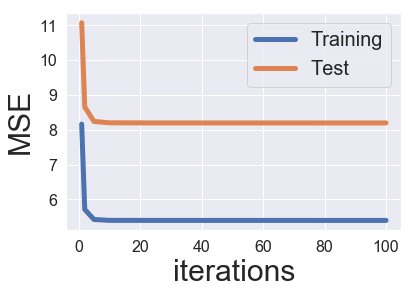

In [104]:
plot_learning_curve(iter_array, MF_ALS)

In [105]:
MF_ALS = ExplicitMF(train_1m, n_factors=20, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test_1m)

Iteration: 1
Train mse: 8.133017313467287
Test mse: 11.385478952329686
Iteration: 2
Train mse: 6.181422331570321
Test mse: 9.510432053967698
Iteration: 5
Train mse: 5.945868319505223
Test mse: 9.181499199125527
Iteration: 10
Train mse: 5.929921005207816
Test mse: 9.163591900058499
Iteration: 25
	current iteration: 10
Train mse: 5.922879579194776
Test mse: 9.155637570112932
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.921741164281515
Test mse: 9.152673442345948
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.921434636456923
Test mse: 9.152593151189302


In [110]:
MF_SGD = ExplicitMF(train_100k, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.142807793060997
Test mse: 1.1796269767247503
Iteration: 2
Train mse: 1.0730325987217215
Test mse: 1.1283621352778417
Iteration: 5
Train mse: 0.9767157588922124
Test mse: 1.0499014864558258
Iteration: 10
Train mse: 0.9190727366615857
Test mse: 0.9988387536431501
Iteration: 25
	current iteration: 10
Train mse: 0.8669457204379917
Test mse: 0.9525818812444498
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.8387251669562131
Test mse: 0.9343161812537658
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.7485848531412769
Test mse: 0.9170005429005551
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.40410579696377263
Test mse: 0.9148070379768369


# Our Proposed GAN

In [111]:
if torch.cuda.is_available() == True:
    device = "cuda"
else:
    device = "cpu"

In [113]:
zero_mask = (train_100k == 0)
positive_feedback = (train_100k > 3)
negative_feedback = ((train_100k < 4) * (1 - zero_mask))

In [114]:
positive_feedback.sum(), negative_feedback.sum()

(49901, 40669)

In [115]:
assert (positive_feedback + negative_feedback != zero_mask).all()
assert (positive_feedback + negative_feedback == 1 - zero_mask).all()

In [116]:
get_sparsity(zero_mask), get_sparsity(positive_feedback), get_sparsity(negative_feedback)

(94.28986095682184, 3.146093059441684, 2.5640459837364746)

In [118]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, mat, p=0.5, batch_size=64):
        '''
        mat is a binary matrix (e.g. positive feedback, or negative feedback)
        '''
        self.batch_size = batch_size
        self.mat = mat
        self.p = p

    def __len__(self):
        return int(np.floor(self.mat.shape[0] / self.batch_size))
    
    def gen_item_GAN(self):
        indexes = np.random.randint(self.mat.shape[0], size=self.batch_size)

        mask = (np.random.rand(self.batch_size, self.mat.shape[1]) > self.p)
        
        y = self.mat[indexes]
        X = self.mat[indexes]*mask # corrupting
        
        return X, y, indexes
        
    def __getitem__(self, index):
        
        indexes = np.random.randint(self.mat.shape[0], size=self.batch_size)

        mask = (np.random.rand(self.batch_size, self.mat.shape[1]) > self.p)
        
        y = self.mat[indexes]
        X = self.mat[indexes]*mask # corrupting
        
        return X, y

In [119]:
generator_negative = DataGenerator(negative_feedback)

In [143]:
x, y, _ = generator_negative.gen_item_GAN()

In [144]:
x.shape, y.shape

((64, 1682), (64, 1682))

In [151]:

class NetD(torch.nn.Module):
    def __init__(self, feat_size):
        super(NetD, self).__init__()
        self.feat_size = feat_size
#         self.use_cuda = True
#         self.feat_size = feat_size
        # top
#         print(self.feat_size*2)
        self.t1 = torch.nn.Linear(self.feat_size, 512)
        # bottom
        self.b1 = torch.nn.Linear(self.feat_size, 512)
        # combined
        self.fc = torch.nn.Linear(2 * 512, self.feat_size)
    def forward(self, xr, xf):
        # get filt
        
        filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
#         if self.use_cuda: 
        idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
        x = filt * x
        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x


class NetG(nn.Module):
    
    def __init__(self, feat_size):

        super(NetG, self).__init__()
        self.feat_size = feat_size
        self.netGen = torch.nn.Sequential( 
                                torch.nn.Linear(nz + self.feat_size, 512), 
#                                 torch.nn.BatchNorm1d(1024),
#                                 torch.nn.ReLU(), 
# #                                 nn.Dropout(0.5),
#                                 torch.nn.Linear(2048, 2048),
                                torch.nn.ReLU(), 
#                                 torch.nn.BatchNorm1d(512),
#                                 nn.Dropout(0.6),
                                torch.nn.Linear(512, self.feat_size), 
                                torch.nn.Sigmoid()
#                                 torch.nn.BatchNorm1d(features_length),
#                                 nn.Dropout(0.7),
#                                 torch.nn.Sigmoid()
                                )

        
    def forward(self, e_mask, x):
        x = self.netGen(x)
#         print(x.shape, )
        x = x * e_mask
        return x
#         return F.dropout(x, 0.7)
#         return 5 * self.netGen(x)
#         return torch.sigmoid(x) 
#         return x*5 # to get values in range [0,5]

In [202]:
gen_losses = []
disc_losses = []
def train_GAN(netD, netG, negative, tr, steps_per_epoch = 200, epochs = 10):
    d_iter = 5
    g_iter = 1
    gen_iterations = 0
#     gen_losses = []
#     disc_losses = []
#     train_losses = []
    for epoch in range(epochs):
        for c in range(steps_per_epoch):
            data_iter = 100
            i = 0
#             while i < 100:
            ############################
            # (1) Update D network
            ###########################
            for p in netD.parameters(): # reset requires_grad
                p.requires_grad = True # they are set to False below in netG update
#             d_iter = d_iter
            j = 0
            while j < d_iter*5:
                j += 1
                # load real data
                i += 1
                if negative:
                    condition, X, idxs = generator_negative.gen_item_GAN()
#                         condition, X, idxs = batch_generator(X_neg, y_neg)
#                 X, _ = data_iter.next()
#                 X = X.view(X.size(0), -1)
#                 X = (X >= 0.5).float()
#                     if cuda: 
                X = torch.from_numpy(X).float().cuda()
#                     X = X + torch.randn(X.size()).cuda() * 0.2
                condition = torch.from_numpy(condition).float().cuda() 
#     + torch.randn(X.size()).cuda() * 0.2
#                 print(condition.shape, X_neg.shape, y_neg.shape)
                real = Variable(X)

                # generate fake data
                noise = torch.randn(batch_size, nz)
#                     if cuda: 
                noise = noise.cuda()
#                     noisev = Variable(noise, volatile = True) # totally freeze netG
                with torch.no_grad():
                    noisev = Variable(noise) # totally freeze netG
                concated = torch.cat((noisev, condition), 1)
#                 print(condition.shape, condition.shape, X.shape, noisev.shape, )
                e_mask = torch.Tensor(tr[idxs]>0).cuda()
#                     print(e_mask.shape, concated.shape, condition.shape)
                fake = Variable(netG(e_mask, concated).data)

                # compute gradient, take step
                netD.zero_grad()
#                 concated_real = torch.cat((real, condition), 1)
#                 print(concated_real)
                out = netD(real, fake)
                outputD = torch.mean(out) + lamba * out.norm()
                stdD = torch.std(out)
                outputD.backward(mone)
                optimizerD.step()
#                     print('AAAAAAAAA mse:=WWWWWWWWWWWWWWWWWWWWWW')
        ############################
        # (2) Update G network
        ###########################

#         g_iter = g_iter
            j = 0
            while j < g_iter:
                j += 1
                for p in netD.parameters():
                    p.requires_grad = False # to avoid computation
                netG.zero_grad()
                # load real data

                i += 1

                if negative:
                    condition, X, idxs = generator_negative.gen_item_GAN()

                X = torch.from_numpy(X).float().cuda()
    #                 X = X + torch.randn(X.size()).cuda() * 0.2
                condition = torch.from_numpy(condition).float().cuda() 
                real = Variable(X)

                # update generator
                noise = torch.randn(batch_size, nz)
                noise = noise.cuda()
                noisev = Variable(noise)
                concated_ = torch.cat((noisev, condition), 1)
                e_mask_ = torch.Tensor(tr[idxs]>0).cuda()

                fake = netG(e_mask_, concated_)
                out = netD(real, fake)
                outputG = torch.mean(out) + lamba * out.norm()
                stdG = torch.std(out)
                outputG.backward(one)
                optimizerG.step()
                gen_iterations += 1
    #             print('AAAAAA')
                eval_loss = F.mse_loss(fake, real, reduction='mean')
    #             eval_losses.append(eval_loss)
    #             print('mse:', eval_loss)
    #             print(outputG.item(), outputD.item())
                gen_losses.append(outputG.item())
                disc_losses.append(outputD.item())
                print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, 100, gen_iterations, outputD.item(), outputG.item()))
    return gen_losses, disc_losses

In [203]:
lrD = 5e-3
lrG = 5e-4
batch_size = 64
cuda = True
epochs = 10
# device = 5
seed = 1
nz = 8
lamba = 1e-4

In [204]:
# networks
netD_neg = NetD(train_100k.shape[1]).cuda()
netG_neg = NetG(train_100k.shape[1]).cuda()
print(netD_neg)
print(netG_neg)
optimizerG = optim.RMSprop(netG_neg.parameters(), lr=lrG, weight_decay=1e-4)
optimizerD = optim.RMSprop(netD_neg.parameters(), lr=lrD, weight_decay=1e-4)
one = torch.FloatTensor([1]).cuda()
mone = (-1 * one).cuda()

NetD(
  (t1): Linear(in_features=1682, out_features=512, bias=True)
  (b1): Linear(in_features=1682, out_features=512, bias=True)
  (fc): Linear(in_features=1024, out_features=1682, bias=True)
)
NetG(
  (netGen): Sequential(
    (0): Linear(in_features=1690, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1682, bias=True)
    (3): Sigmoid()
  )
)


In [205]:
netD_neg.train()
netG_neg.train()
# gen_losses, disc_losses = train_GAN(netD_neg, netG_neg, negative=True)
train_GAN(netD_neg, netG_neg, tr=train_100k, epochs=10, negative=True)

[0/10][26/100][1] Loss_D: 0.012087 Loss_G: 0.015088 
[0/10][26/100][2] Loss_D: 0.004970 Loss_G: 0.011500 
[0/10][26/100][3] Loss_D: 0.008385 Loss_G: 0.009363 
[0/10][26/100][4] Loss_D: 0.005430 Loss_G: 0.002678 
[0/10][26/100][5] Loss_D: 0.000809 Loss_G: 0.000955 
[0/10][26/100][6] Loss_D: 0.001399 Loss_G: 0.002833 
[0/10][26/100][7] Loss_D: 0.000421 Loss_G: 0.000294 
[0/10][26/100][8] Loss_D: 0.001978 Loss_G: -0.001052 
[0/10][26/100][9] Loss_D: 0.002113 Loss_G: 0.003058 
[0/10][26/100][10] Loss_D: 0.000651 Loss_G: 0.001420 
[0/10][26/100][11] Loss_D: 0.000195 Loss_G: 0.001388 
[0/10][26/100][12] Loss_D: 0.002154 Loss_G: 0.000524 
[0/10][26/100][13] Loss_D: 0.000834 Loss_G: 0.002114 
[0/10][26/100][14] Loss_D: 0.002443 Loss_G: 0.000701 
[0/10][26/100][15] Loss_D: 0.000421 Loss_G: 0.002086 
[0/10][26/100][16] Loss_D: 0.003219 Loss_G: 0.004532 
[0/10][26/100][17] Loss_D: 0.001307 Loss_G: 0.002597 
[0/10][26/100][18] Loss_D: 0.001849 Loss_G: 0.004025 
[0/10][26/100][19] Loss_D: 0.001137 

[0/10][26/100][152] Loss_D: 0.001650 Loss_G: 0.003534 
[0/10][26/100][153] Loss_D: 0.002910 Loss_G: 0.002714 
[0/10][26/100][154] Loss_D: 0.001373 Loss_G: 0.002033 
[0/10][26/100][155] Loss_D: 0.002888 Loss_G: 0.002314 
[0/10][26/100][156] Loss_D: 0.003377 Loss_G: 0.001553 
[0/10][26/100][157] Loss_D: 0.003323 Loss_G: 0.004364 
[0/10][26/100][158] Loss_D: 0.002229 Loss_G: 0.004223 
[0/10][26/100][159] Loss_D: 0.002176 Loss_G: 0.002869 
[0/10][26/100][160] Loss_D: 0.002034 Loss_G: 0.001248 
[0/10][26/100][161] Loss_D: 0.004255 Loss_G: 0.001665 
[0/10][26/100][162] Loss_D: 0.002156 Loss_G: 0.002910 
[0/10][26/100][163] Loss_D: 0.002349 Loss_G: 0.003328 
[0/10][26/100][164] Loss_D: 0.001229 Loss_G: 0.003339 
[0/10][26/100][165] Loss_D: 0.002214 Loss_G: 0.002556 
[0/10][26/100][166] Loss_D: 0.003886 Loss_G: 0.000184 
[0/10][26/100][167] Loss_D: 0.003272 Loss_G: 0.003361 
[0/10][26/100][168] Loss_D: 0.001674 Loss_G: 0.001858 
[0/10][26/100][169] Loss_D: 0.001446 Loss_G: 0.003461 
[0/10][26/

[1/10][26/100][301] Loss_D: 0.002372 Loss_G: 0.001548 
[1/10][26/100][302] Loss_D: 0.002248 Loss_G: 0.002999 
[1/10][26/100][303] Loss_D: 0.003680 Loss_G: 0.002452 
[1/10][26/100][304] Loss_D: 0.003587 Loss_G: 0.002650 
[1/10][26/100][305] Loss_D: 0.003831 Loss_G: 0.002544 
[1/10][26/100][306] Loss_D: 0.004565 Loss_G: 0.002764 
[1/10][26/100][307] Loss_D: 0.004842 Loss_G: 0.001201 
[1/10][26/100][308] Loss_D: 0.004395 Loss_G: 0.002799 
[1/10][26/100][309] Loss_D: 0.001112 Loss_G: 0.002917 
[1/10][26/100][310] Loss_D: 0.002635 Loss_G: 0.004290 
[1/10][26/100][311] Loss_D: 0.002732 Loss_G: 0.002151 
[1/10][26/100][312] Loss_D: 0.003240 Loss_G: 0.001802 
[1/10][26/100][313] Loss_D: 0.002164 Loss_G: 0.002715 
[1/10][26/100][314] Loss_D: 0.000409 Loss_G: 0.002146 
[1/10][26/100][315] Loss_D: 0.003111 Loss_G: 0.004301 
[1/10][26/100][316] Loss_D: 0.005148 Loss_G: 0.003258 
[1/10][26/100][317] Loss_D: 0.003117 Loss_G: 0.004852 
[1/10][26/100][318] Loss_D: 0.002145 Loss_G: 0.002360 
[1/10][26/

[2/10][26/100][450] Loss_D: 0.001516 Loss_G: 0.003678 
[2/10][26/100][451] Loss_D: 0.001981 Loss_G: 0.002764 
[2/10][26/100][452] Loss_D: 0.002041 Loss_G: 0.001292 
[2/10][26/100][453] Loss_D: 0.002544 Loss_G: 0.002003 
[2/10][26/100][454] Loss_D: 0.003786 Loss_G: 0.002933 
[2/10][26/100][455] Loss_D: 0.005093 Loss_G: 0.003009 
[2/10][26/100][456] Loss_D: 0.001415 Loss_G: 0.002430 
[2/10][26/100][457] Loss_D: 0.004683 Loss_G: 0.003706 
[2/10][26/100][458] Loss_D: 0.001700 Loss_G: 0.003699 
[2/10][26/100][459] Loss_D: 0.003692 Loss_G: 0.003024 
[2/10][26/100][460] Loss_D: 0.000586 Loss_G: 0.003178 
[2/10][26/100][461] Loss_D: 0.004567 Loss_G: 0.004311 
[2/10][26/100][462] Loss_D: 0.004065 Loss_G: -0.000172 
[2/10][26/100][463] Loss_D: 0.001691 Loss_G: 0.001705 
[2/10][26/100][464] Loss_D: 0.001830 Loss_G: 0.003100 
[2/10][26/100][465] Loss_D: 0.004785 Loss_G: 0.001930 
[2/10][26/100][466] Loss_D: 0.003047 Loss_G: 0.003423 
[2/10][26/100][467] Loss_D: 0.004276 Loss_G: 0.003520 
[2/10][26

[2/10][26/100][599] Loss_D: 0.001638 Loss_G: 0.003764 
[2/10][26/100][600] Loss_D: 0.002327 Loss_G: 0.002195 
[3/10][26/100][601] Loss_D: 0.001475 Loss_G: 0.003072 
[3/10][26/100][602] Loss_D: 0.003281 Loss_G: 0.001635 
[3/10][26/100][603] Loss_D: 0.002632 Loss_G: 0.001150 
[3/10][26/100][604] Loss_D: 0.003867 Loss_G: 0.001764 
[3/10][26/100][605] Loss_D: 0.003179 Loss_G: 0.002596 
[3/10][26/100][606] Loss_D: 0.002367 Loss_G: 0.003969 
[3/10][26/100][607] Loss_D: 0.003617 Loss_G: 0.004697 
[3/10][26/100][608] Loss_D: 0.001709 Loss_G: 0.001449 
[3/10][26/100][609] Loss_D: 0.000370 Loss_G: 0.001799 
[3/10][26/100][610] Loss_D: 0.001792 Loss_G: 0.002036 
[3/10][26/100][611] Loss_D: 0.002417 Loss_G: 0.001967 
[3/10][26/100][612] Loss_D: 0.002970 Loss_G: 0.001681 
[3/10][26/100][613] Loss_D: 0.002919 Loss_G: 0.002511 
[3/10][26/100][614] Loss_D: 0.002392 Loss_G: 0.002992 
[3/10][26/100][615] Loss_D: 0.002207 Loss_G: 0.002047 
[3/10][26/100][616] Loss_D: 0.002638 Loss_G: 0.002525 
[3/10][26/

[3/10][26/100][748] Loss_D: 0.002993 Loss_G: 0.003807 
[3/10][26/100][749] Loss_D: 0.001752 Loss_G: 0.001853 
[3/10][26/100][750] Loss_D: 0.001851 Loss_G: 0.001587 
[3/10][26/100][751] Loss_D: 0.002166 Loss_G: 0.000517 
[3/10][26/100][752] Loss_D: 0.003723 Loss_G: 0.002335 
[3/10][26/100][753] Loss_D: 0.002990 Loss_G: 0.002285 
[3/10][26/100][754] Loss_D: 0.001990 Loss_G: 0.001991 
[3/10][26/100][755] Loss_D: 0.002955 Loss_G: 0.002651 
[3/10][26/100][756] Loss_D: 0.000676 Loss_G: 0.003252 
[3/10][26/100][757] Loss_D: 0.001853 Loss_G: 0.006936 
[3/10][26/100][758] Loss_D: 0.003297 Loss_G: 0.001921 
[3/10][26/100][759] Loss_D: 0.002130 Loss_G: 0.001457 
[3/10][26/100][760] Loss_D: 0.003723 Loss_G: 0.003164 
[3/10][26/100][761] Loss_D: 0.001319 Loss_G: 0.003865 
[3/10][26/100][762] Loss_D: 0.002516 Loss_G: 0.001967 
[3/10][26/100][763] Loss_D: 0.002654 Loss_G: 0.003954 
[3/10][26/100][764] Loss_D: 0.004762 Loss_G: 0.003516 
[3/10][26/100][765] Loss_D: 0.002453 Loss_G: 0.001947 
[3/10][26/

[4/10][26/100][897] Loss_D: 0.004270 Loss_G: 0.003112 
[4/10][26/100][898] Loss_D: 0.002882 Loss_G: 0.001647 
[4/10][26/100][899] Loss_D: 0.004530 Loss_G: 0.002929 
[4/10][26/100][900] Loss_D: 0.000293 Loss_G: -0.000045 
[4/10][26/100][901] Loss_D: 0.003035 Loss_G: 0.003477 
[4/10][26/100][902] Loss_D: 0.000969 Loss_G: 0.001896 
[4/10][26/100][903] Loss_D: 0.002874 Loss_G: 0.001321 
[4/10][26/100][904] Loss_D: 0.003027 Loss_G: 0.002142 
[4/10][26/100][905] Loss_D: 0.003356 Loss_G: 0.001568 
[4/10][26/100][906] Loss_D: 0.002885 Loss_G: 0.002049 
[4/10][26/100][907] Loss_D: 0.001506 Loss_G: 0.003561 
[4/10][26/100][908] Loss_D: 0.001879 Loss_G: 0.003072 
[4/10][26/100][909] Loss_D: 0.001921 Loss_G: 0.000947 
[4/10][26/100][910] Loss_D: 0.003334 Loss_G: 0.001589 
[4/10][26/100][911] Loss_D: 0.003564 Loss_G: 0.000838 
[4/10][26/100][912] Loss_D: 0.003155 Loss_G: 0.006000 
[4/10][26/100][913] Loss_D: 0.001431 Loss_G: 0.002085 
[4/10][26/100][914] Loss_D: 0.000598 Loss_G: 0.003080 
[4/10][26

[5/10][26/100][1046] Loss_D: 0.001192 Loss_G: 0.003445 
[5/10][26/100][1047] Loss_D: 0.002580 Loss_G: 0.001147 
[5/10][26/100][1048] Loss_D: 0.002004 Loss_G: 0.001482 
[5/10][26/100][1049] Loss_D: 0.001884 Loss_G: 0.003323 
[5/10][26/100][1050] Loss_D: 0.004350 Loss_G: -0.001761 
[5/10][26/100][1051] Loss_D: 0.002169 Loss_G: 0.001142 
[5/10][26/100][1052] Loss_D: 0.002459 Loss_G: 0.000947 
[5/10][26/100][1053] Loss_D: 0.004246 Loss_G: 0.003220 
[5/10][26/100][1054] Loss_D: 0.005561 Loss_G: 0.002164 
[5/10][26/100][1055] Loss_D: 0.003240 Loss_G: 0.003203 
[5/10][26/100][1056] Loss_D: 0.002464 Loss_G: 0.001015 
[5/10][26/100][1057] Loss_D: 0.002413 Loss_G: 0.003185 
[5/10][26/100][1058] Loss_D: 0.004572 Loss_G: 0.002314 
[5/10][26/100][1059] Loss_D: 0.002217 Loss_G: 0.003163 
[5/10][26/100][1060] Loss_D: 0.002359 Loss_G: 0.003968 
[5/10][26/100][1061] Loss_D: 0.002931 Loss_G: 0.002584 
[5/10][26/100][1062] Loss_D: 0.003633 Loss_G: 0.001561 
[5/10][26/100][1063] Loss_D: 0.006169 Loss_G: 0

[5/10][26/100][1193] Loss_D: 0.001601 Loss_G: 0.002308 
[5/10][26/100][1194] Loss_D: 0.002325 Loss_G: 0.001954 
[5/10][26/100][1195] Loss_D: 0.004919 Loss_G: 0.002290 
[5/10][26/100][1196] Loss_D: 0.002682 Loss_G: 0.007882 
[5/10][26/100][1197] Loss_D: 0.002396 Loss_G: 0.001871 
[5/10][26/100][1198] Loss_D: 0.003366 Loss_G: 0.004840 
[5/10][26/100][1199] Loss_D: 0.001838 Loss_G: 0.001419 
[5/10][26/100][1200] Loss_D: 0.000953 Loss_G: 0.001666 
[6/10][26/100][1201] Loss_D: 0.003362 Loss_G: -0.001339 
[6/10][26/100][1202] Loss_D: 0.003113 Loss_G: 0.002715 
[6/10][26/100][1203] Loss_D: 0.001119 Loss_G: 0.001512 
[6/10][26/100][1204] Loss_D: 0.001360 Loss_G: 0.001884 
[6/10][26/100][1205] Loss_D: 0.001229 Loss_G: 0.002255 
[6/10][26/100][1206] Loss_D: 0.007470 Loss_G: 0.002098 
[6/10][26/100][1207] Loss_D: 0.002776 Loss_G: 0.003473 
[6/10][26/100][1208] Loss_D: 0.001968 Loss_G: 0.001492 
[6/10][26/100][1209] Loss_D: 0.004213 Loss_G: 0.001387 
[6/10][26/100][1210] Loss_D: 0.002931 Loss_G: 0

[6/10][26/100][1340] Loss_D: 0.003652 Loss_G: 0.003030 
[6/10][26/100][1341] Loss_D: 0.002465 Loss_G: 0.005252 
[6/10][26/100][1342] Loss_D: 0.003879 Loss_G: 0.003069 
[6/10][26/100][1343] Loss_D: 0.002397 Loss_G: 0.001710 
[6/10][26/100][1344] Loss_D: 0.001659 Loss_G: 0.002197 
[6/10][26/100][1345] Loss_D: 0.003360 Loss_G: 0.003900 
[6/10][26/100][1346] Loss_D: 0.003048 Loss_G: 0.002625 
[6/10][26/100][1347] Loss_D: 0.001544 Loss_G: 0.001043 
[6/10][26/100][1348] Loss_D: 0.004113 Loss_G: 0.003787 
[6/10][26/100][1349] Loss_D: 0.003951 Loss_G: 0.002537 
[6/10][26/100][1350] Loss_D: 0.004574 Loss_G: 0.001215 
[6/10][26/100][1351] Loss_D: 0.002629 Loss_G: 0.004124 
[6/10][26/100][1352] Loss_D: 0.003218 Loss_G: 0.001994 
[6/10][26/100][1353] Loss_D: 0.003685 Loss_G: 0.002315 
[6/10][26/100][1354] Loss_D: 0.002697 Loss_G: 0.002458 
[6/10][26/100][1355] Loss_D: 0.003520 Loss_G: 0.001900 
[6/10][26/100][1356] Loss_D: 0.000992 Loss_G: 0.001363 
[6/10][26/100][1357] Loss_D: 0.004675 Loss_G: 0.

[7/10][26/100][1487] Loss_D: 0.001965 Loss_G: 0.002849 
[7/10][26/100][1488] Loss_D: 0.002913 Loss_G: 0.002156 
[7/10][26/100][1489] Loss_D: 0.001691 Loss_G: 0.002613 
[7/10][26/100][1490] Loss_D: 0.001634 Loss_G: 0.002130 
[7/10][26/100][1491] Loss_D: 0.003907 Loss_G: 0.002053 
[7/10][26/100][1492] Loss_D: 0.002752 Loss_G: 0.001381 
[7/10][26/100][1493] Loss_D: 0.002140 Loss_G: 0.003838 
[7/10][26/100][1494] Loss_D: 0.003575 Loss_G: 0.003588 
[7/10][26/100][1495] Loss_D: 0.002519 Loss_G: 0.002288 
[7/10][26/100][1496] Loss_D: 0.001994 Loss_G: 0.002685 
[7/10][26/100][1497] Loss_D: 0.001699 Loss_G: 0.002890 
[7/10][26/100][1498] Loss_D: 0.001647 Loss_G: 0.005059 
[7/10][26/100][1499] Loss_D: 0.002003 Loss_G: 0.002173 
[7/10][26/100][1500] Loss_D: 0.001918 Loss_G: 0.001773 
[7/10][26/100][1501] Loss_D: 0.001763 Loss_G: 0.002832 
[7/10][26/100][1502] Loss_D: 0.004306 Loss_G: 0.002392 
[7/10][26/100][1503] Loss_D: 0.003089 Loss_G: 0.003696 
[7/10][26/100][1504] Loss_D: 0.005219 Loss_G: 0.

[8/10][26/100][1634] Loss_D: 0.003664 Loss_G: 0.002980 
[8/10][26/100][1635] Loss_D: 0.003218 Loss_G: 0.004434 
[8/10][26/100][1636] Loss_D: 0.002367 Loss_G: 0.002041 
[8/10][26/100][1637] Loss_D: 0.003369 Loss_G: 0.005300 
[8/10][26/100][1638] Loss_D: 0.002763 Loss_G: 0.002825 
[8/10][26/100][1639] Loss_D: 0.004250 Loss_G: 0.001523 
[8/10][26/100][1640] Loss_D: 0.003487 Loss_G: 0.004189 
[8/10][26/100][1641] Loss_D: 0.004970 Loss_G: 0.002829 
[8/10][26/100][1642] Loss_D: 0.001995 Loss_G: 0.002354 
[8/10][26/100][1643] Loss_D: 0.002439 Loss_G: 0.005154 
[8/10][26/100][1644] Loss_D: 0.005568 Loss_G: 0.001317 
[8/10][26/100][1645] Loss_D: 0.001403 Loss_G: 0.002422 
[8/10][26/100][1646] Loss_D: 0.000532 Loss_G: 0.001972 
[8/10][26/100][1647] Loss_D: 0.002941 Loss_G: 0.002522 
[8/10][26/100][1648] Loss_D: 0.003760 Loss_G: 0.003727 
[8/10][26/100][1649] Loss_D: 0.002537 Loss_G: 0.002009 
[8/10][26/100][1650] Loss_D: 0.002320 Loss_G: 0.002986 
[8/10][26/100][1651] Loss_D: 0.000739 Loss_G: 0.

[8/10][26/100][1781] Loss_D: 0.002389 Loss_G: 0.002148 
[8/10][26/100][1782] Loss_D: 0.002012 Loss_G: 0.004329 
[8/10][26/100][1783] Loss_D: 0.004873 Loss_G: 0.002662 
[8/10][26/100][1784] Loss_D: 0.001523 Loss_G: 0.001375 
[8/10][26/100][1785] Loss_D: 0.000127 Loss_G: 0.002760 
[8/10][26/100][1786] Loss_D: 0.002576 Loss_G: 0.003632 
[8/10][26/100][1787] Loss_D: 0.001384 Loss_G: 0.004447 
[8/10][26/100][1788] Loss_D: 0.002252 Loss_G: 0.002149 
[8/10][26/100][1789] Loss_D: 0.001989 Loss_G: 0.004832 
[8/10][26/100][1790] Loss_D: 0.002693 Loss_G: 0.003308 
[8/10][26/100][1791] Loss_D: 0.003539 Loss_G: 0.002051 
[8/10][26/100][1792] Loss_D: 0.003006 Loss_G: 0.003700 
[8/10][26/100][1793] Loss_D: 0.002093 Loss_G: 0.001422 
[8/10][26/100][1794] Loss_D: 0.003773 Loss_G: 0.002367 
[8/10][26/100][1795] Loss_D: 0.002315 Loss_G: 0.002852 
[8/10][26/100][1796] Loss_D: 0.003472 Loss_G: 0.003191 
[8/10][26/100][1797] Loss_D: 0.002012 Loss_G: 0.005275 
[8/10][26/100][1798] Loss_D: 0.002361 Loss_G: 0.

[9/10][26/100][1928] Loss_D: 0.004302 Loss_G: 0.001951 
[9/10][26/100][1929] Loss_D: 0.001869 Loss_G: 0.003298 
[9/10][26/100][1930] Loss_D: 0.000162 Loss_G: 0.003871 
[9/10][26/100][1931] Loss_D: 0.002967 Loss_G: 0.002514 
[9/10][26/100][1932] Loss_D: 0.004325 Loss_G: 0.003446 
[9/10][26/100][1933] Loss_D: 0.003358 Loss_G: 0.005165 
[9/10][26/100][1934] Loss_D: 0.000997 Loss_G: 0.003416 
[9/10][26/100][1935] Loss_D: 0.002714 Loss_G: 0.000408 
[9/10][26/100][1936] Loss_D: 0.003771 Loss_G: 0.002444 
[9/10][26/100][1937] Loss_D: 0.001834 Loss_G: 0.003084 
[9/10][26/100][1938] Loss_D: 0.002493 Loss_G: 0.008069 
[9/10][26/100][1939] Loss_D: 0.000990 Loss_G: 0.001743 
[9/10][26/100][1940] Loss_D: 0.003918 Loss_G: 0.002804 
[9/10][26/100][1941] Loss_D: 0.003465 Loss_G: 0.004021 
[9/10][26/100][1942] Loss_D: 0.002551 Loss_G: 0.001750 
[9/10][26/100][1943] Loss_D: 0.002792 Loss_G: 0.001495 
[9/10][26/100][1944] Loss_D: 0.002222 Loss_G: 0.003684 
[9/10][26/100][1945] Loss_D: 0.002112 Loss_G: 0.

([0.015087549574673176,
  0.011499668471515179,
  0.009362959302961826,
  0.0026781747583299875,
  0.0009550042450428009,
  0.0028326816391199827,
  0.00029393803561106324,
  -0.001052424544468522,
  0.003058132715523243,
  0.001420168555341661,
  0.0013879818143323064,
  0.0005235265707597136,
  0.0021142871119081974,
  0.0007014574948698282,
  0.0020857159979641438,
  0.004531828220933676,
  0.0025970120914280415,
  0.004024721682071686,
  0.0029805772937834263,
  0.0035233059898018837,
  0.001278858631849289,
  0.003827510867267847,
  0.0020897332578897476,
  0.0015348732704296708,
  0.0006372160860337317,
  0.0042740413919091225,
  0.0025846052449196577,
  0.00130808528047055,
  0.00429991539567709,
  0.002744811587035656,
  0.0030942216981202364,
  0.0009747726144269109,
  0.0029646819457411766,
  0.0028301337733864784,
  0.0014303538482636213,
  0.003806662280112505,
  0.0011024657869711518,
  0.0006811631610617042,
  0.0015012789517641068,
  0.004456625785678625,
  0.00290772295

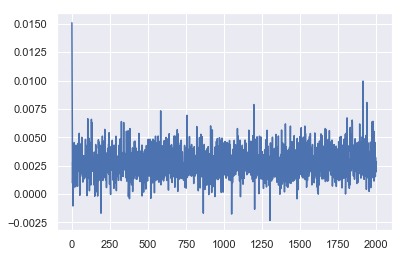

In [206]:
plt.plot(gen_losses)
plt.show()

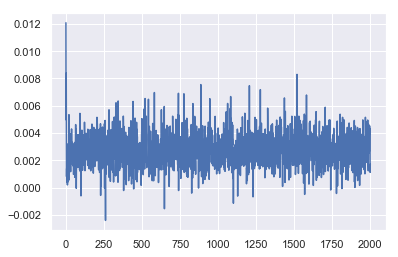

In [207]:
plt.plot(disc_losses)
plt.show()

In [208]:
# to test without train
netD_neg_test = NetD(train_100k.shape[1]).cuda()
netG_neg_test = NetG(train_100k.shape[1]).cuda()

netD_neg_test.eval()
netG_neg_test.eval()

NetG(
  (netGen): Sequential(
    (0): Linear(in_features=1690, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1682, bias=True)
    (3): Sigmoid()
  )
)

In [209]:
netD_neg.eval()
netG_neg.eval()

NetG(
  (netGen): Sequential(
    (0): Linear(in_features=1690, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1682, bias=True)
    (3): Sigmoid()
  )
)

In [210]:
# checking accuraccy
condition = torch.from_numpy(negative_feedback).float().cuda() 
noise = torch.randn(condition.shape[0], nz).cuda()
# e_mask = torch.Tensor(to_add_negative).cuda()
e_mask = torch.Tensor(train_100k > 0).cuda()

concated = torch.cat((noise, condition), 1)
fake_accur_check = netG_neg(e_mask, concated)

In [211]:
# without train
fake_test_accur_check = netG_neg_test(e_mask, concated)

In [212]:
fake_accur_check_ = (fake_accur_check.detach().cpu().numpy() > 0.5).astype(int)

In [213]:
fake_test_accur_check = (fake_test_accur_check.detach().cpu().numpy() > 0.5).astype(int)

In [214]:
(fake_accur_check_ * negative_feedback).sum(), (fake_accur_check_ * positive_feedback).sum()

(24362, 13579)

In [215]:
(fake_test_accur_check * negative_feedback).sum(), (fake_test_accur_check * positive_feedback).sum()

(20075, 25478)

In [216]:
# accuracy on negative items
(fake_accur_check_ * negative_feedback).sum() / negative_feedback.sum()

0.5990312031276894

In [217]:
# accuracy on negative items - WITHOUT TRAIN 
(fake_test_accur_check * negative_feedback).sum() / negative_feedback.sum()

0.49361921856942637

In [218]:
# accuracy on positive items
((1-fake_accur_check_) * positive_feedback).sum() / positive_feedback.sum()

0.7278812047854752

In [219]:
# accuracy on positive items - WITHOUT TRAIN 
((1-fake_test_accur_check) * positive_feedback).sum() / positive_feedback.sum()

0.4894290695577243

In [220]:
# accuracy on positive items - WITHOUT TRAIN 
((1-fake_test_accur_check) * positive_feedback).sum() / positive_feedback.sum()

0.4894290695577243

In [221]:
import gc
gc.collect()

10569

In [222]:
del fake_accur_check
del fake_test_accur_check 
del e_mask

In [224]:
# condition, X, idxs = batch_generator(y_neg, to_add_negative, batch_size=256)
# predicting on ngetavie feedbacks
condition = torch.from_numpy(negative_feedback).float().cuda()
# X = torch.from_numpy(to_add_negative).cuda()


noise = torch.randn(condition.shape[0], nz).cuda()
# e_mask = torch.Tensor(to_add_negative).cuda()
e_mask = torch.Tensor(train_100k == 0).cuda()

concated = torch.cat((noise, condition), 1)
fake = netG_neg(e_mask, concated)

In [225]:
fake = (fake >0.9).cpu().numpy()

In [226]:
fake.sum()

536

In [228]:
to_augment_negative = fake

In [230]:
p_probs = [(train_100k == 1).sum()/((train_100k > 0) & (train_100k < 4)).sum(), (train_100k == 2).sum()/(((train_100k > 0) & (train_100k < 4))).sum(), (train_100k == 3).sum()/((train_100k > 0) & (train_100k < 4)).sum()]
p_probs

[0.13777078364356143, 0.2542968846049817, 0.6079323317514569]

In [233]:
augmented_train_100k = train_100k + to_augment_negative

In [234]:
get_sparsity(train_100k), get_sparsity(augmented_train_100k)

(5.710139043178159, 5.743932070970402)

In [248]:
MF_SGD = ExplicitMF(train_100k, 40, learning='sgd', verbose=True)
MF_SGD.calculate_learning_curve([300], test_100k, learning_rate=0.001)

Iteration: 300
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
	current iteration: 110
	current iteration: 120
	current iteration: 130
	current iteration: 140
	current iteration: 150
	current iteration: 160
	current iteration: 170
	current iteration: 180
	current iteration: 190
	current iteration: 200
	current iteration: 210
	current iteration: 220
	current iteration: 230
	current iteration: 240
	current iteration: 250
	current iteration: 260
	current iteration: 270
	current iteration: 280
	current iteration: 290
	current iteration: 300
Train mse: 0.24780276795013206
Test mse: 0.9911321751624483


In [249]:
MF_SGD = ExplicitMF(augmented_train_100k, 40, learning='sgd', verbose=True)
MF_SGD.calculate_learning_curve([300], test_100k, learning_rate=0.001)

Iteration: 300
	current iteration: 10
	current iteration: 20


KeyboardInterrupt: 

In [247]:
MF_SGD = ExplicitMF(train_100k, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.142822581632546
Test mse: 1.179626365384201
Iteration: 2
Train mse: 1.0730309645422471
Test mse: 1.1283647354414428
Iteration: 5
Train mse: 0.976704786728581
Test mse: 1.0498895036356708
Iteration: 10
Train mse: 0.9191190735106731
Test mse: 0.99882388507181
Iteration: 25
	current iteration: 10
Train mse: 0.8670975465312848
Test mse: 0.9525039875303193
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.8395297477072872
Test mse: 0.9342662870213886
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.7572607163519403
Test mse: 0.917558302954112
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.40646564364302945
Test mse: 0.9047525011076776


In [246]:
MF_SGD = ExplicitMF(augmented_train_100k, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.1583192976603522
Test mse: 1.1778921160446154
Iteration: 2
Train mse: 1.0827823219708648
Test mse: 1.124826924658217
Iteration: 5
Train mse: 0.9809962544391533
Test mse: 1.0456674228179015
Iteration: 10
Train mse: 0.9217915122656181
Test mse: 0.9960992361685521
Iteration: 25
	current iteration: 10
Train mse: 0.8695835693024129
Test mse: 0.9521000726072203
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.8421152097706776
Test mse: 0.9345373660525688
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.755397379978269
Test mse: 0.916590796822304
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.40575111332308983
Test mse: 0.906762464167835


In [245]:
MF_ALS = ExplicitMF(augmented_train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 7.365331085064962
Test mse: 10.594736049344187
Iteration: 2
Train mse: 5.692327274625398
Test mse: 8.63601159502765
Iteration: 5
Train mse: 5.390926482500714
Test mse: 8.223490099578223
Iteration: 10
Train mse: 5.382053601809805
Test mse: 8.224694402460047
Iteration: 25
	current iteration: 10
Train mse: 5.365488278184999
Test mse: 8.201579412685142
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.3600334033203785
Test mse: 8.193471712808986
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.35983226130889
Test mse: 8.193220337124336


In [243]:
MF_ALS = ExplicitMF(train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 7.414043254856359
Test mse: 10.597071517103002
Iteration: 2
Train mse: 5.729849556962303
Test mse: 8.637501957776392
Iteration: 5
Train mse: 5.425216634306679
Test mse: 8.224449939246286
Iteration: 10
Train mse: 5.416034494374579
Test mse: 8.225911144030166
Iteration: 25
	current iteration: 10
Train mse: 5.405244808568524
Test mse: 8.212123871641975
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.394015977369497
Test mse: 8.19475571062152
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.3937671853374605
Test mse: 8.19442505144314


In [250]:
# until test error starts to rise
MF_ALS = ExplicitMF(augmented_train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200]
MF_ALS.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 7.365331085064962
Test mse: 10.594736049344187
Iteration: 2
Train mse: 5.692327274625398
Test mse: 8.63601159502765
Iteration: 5
Train mse: 5.390926482500714
Test mse: 8.223490099578223
Iteration: 10
Train mse: 5.382053601809805
Test mse: 8.224694402460047
Iteration: 25
	current iteration: 10
Train mse: 5.365488278184999
Test mse: 8.201579412685142
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.3600334033203785
Test mse: 8.193471712808986
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.35983226130889
Test mse: 8.193220337124336
Iteration: 120
	current iteration: 10
	current iteration: 20
Train mse: 5.35978032575701
Test mse: 8.193157746225948
Iteration: 140
	current iteration: 10
	current iteration: 20
Train mse: 5.359732338000212
Test mse: 8.193099816595986
Iteration: 160
	current iteration: 10
	current iteration: 20
Train mse: 5.359687859300

In [251]:
# until test error starts to rise
MF_ALS = ExplicitMF(train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200]
MF_ALS.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 7.414043254856359
Test mse: 10.597071517103002
Iteration: 2
Train mse: 5.729849556962303
Test mse: 8.637501957776392
Iteration: 5
Train mse: 5.425216634306679
Test mse: 8.224449939246286
Iteration: 10
Train mse: 5.416034494374579
Test mse: 8.225911144030166
Iteration: 25
	current iteration: 10
Train mse: 5.405244808568524
Test mse: 8.212123871641975
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.394015977369497
Test mse: 8.19475571062152
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.3937671853374605
Test mse: 8.19442505144314
Iteration: 120
	current iteration: 10
	current iteration: 20
Train mse: 5.393714646752196
Test mse: 8.194362304310943
Iteration: 140
	current iteration: 10
	current iteration: 20
Train mse: 5.393666122560651
Test mse: 8.194304259396569
Iteration: 160
	current iteration: 10
	current iteration: 20
Train mse: 5.39362115513

In [ ]:
# until test error starts to rise
MF_ALS = ExplicitMF(train_100k, n_factors=10, learning='sgd',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200, 220]
MF_ALS.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
